<p style='color: darkorange; font-size: 2.5em; font-weight: bold; text-align: left;'>
    Verarbeiten großer Datenbestände mit DuckDB 🦆</p>

### **Installation von DuckDB und Verbindung zu DuckDB (hier in-Memory-Verarbeitung)**

In [22]:
%%capture
%pip install duckdb

In [41]:
import duckdb

# Verbindung zur in-memory DuckDB-Datenbank (':memory:') herstellen; Voraussetzung: DuckDB muss installiert sein, ':memory:' muss als Vorgabe so gesetzt sein
conn = duckdb.connect(':memory:')

### **Inspektion der Daten via SQL**

In [42]:
# Inspektion der Daten und Test der Verbindung zur Datenquelle, die über die untere URL zu erreichen ist
result = conn.execute("""
DESCRIBE SELECT * FROM 'https://media.githubusercontent.com/media/swrobuts/Flights/main/airports.csv';
""").fetchall()

# Ausgabe des Ergebnisses
for row in result:
    print(row)

('IATA_CODE', 'VARCHAR', 'YES', None, None, None)
('AIRPORT', 'VARCHAR', 'YES', None, None, None)
('CITY', 'VARCHAR', 'YES', None, None, None)
('STATE', 'VARCHAR', 'YES', None, None, None)
('COUNTRY', 'VARCHAR', 'YES', None, None, None)
('LATITUDE', 'DOUBLE', 'YES', None, None, None)
('LONGITUDE', 'DOUBLE', 'YES', None, None, None)


### **Aufbau und Befüllen der Tabelle `airports`**

In [43]:
import pandas as pd

# Verbindung zur in-memory DuckDB-Datenbank herstellen; Voraussetzung: DuckDB muss installiert sein
conn = duckdb.connect(':memory:')

# Sequenz und Tabelle "airports" erstellen
conn.execute("""
CREATE SEQUENCE IF NOT EXISTS airport_id
INCREMENT BY 1 MINVALUE 0;
""")

conn.execute("""
CREATE TABLE IF NOT EXISTS airports (
    airport_id INTEGER PRIMARY KEY DEFAULT(nextval('airport_id')),
    iata_code VARCHAR(5),
    airport VARCHAR(255),
    city VARCHAR(255),
    state VARCHAR(255),
    country VARCHAR(255),
    latitude DOUBLE,
    longitude DOUBLE,
    CONSTRAINT airport_id UNIQUE (airport_id)
);
""")

# Befüllen der angelegten Tabelle bzw. Relation "airports" aus der csv-Datei
conn.execute("""
INSERT INTO airports("iata_code", "airport","city","state","country","latitude","longitude")
SELECT DISTINCT "IATA_CODE", "AIRPORT", "CITY", "STATE","COUNTRY","LATITUDE","LONGITUDE"
FROM 'https://media.githubusercontent.com/media/swrobuts/Flights/main/airports.csv';
""")

# Überführt die Daten aus der Relation "airports" in ein pandas DataFrame
airports_df = conn.execute("SELECT * FROM airports;").df()

# Einige Daten aus der Tabelle "airports" abfragen, um zu testen
airports_df.head()

,airport_id,iata_code,airport,city,state,country,latitude,longitude
0,176,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
1,177,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
2,178,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603
3,179,BGR,Bangor International Airport,Bangor,ME,USA,44.80744,-68.82814
4,180,BQN,Rafael Hernández Airport,Aguadilla,PR,USA,18.49486,-67.12944


### **Aufbau und Befüllen der Tabelle `airlines`**

In [49]:
# Anlegen und Befüllen der Tabelle "airlines"
conn.execute("""
CREATE SEQUENCE IF NOT EXISTS "airline_id"
INCREMENT BY 1 MINVALUE 100;

CREATE TABLE IF NOT EXISTS airlines
(
    "airline_id" INTEGER PRIMARY KEY DEFAULT(nextval('airline_id')),
    "iata_code" VARCHAR(10),
    "airline" VARCHAR(255),
    CONSTRAINT "airline_id" UNIQUE ("airline_id")
    );

--- Befüllen der angelegten Tabelle "airlines"
INSERT INTO airlines("iata_code","airline")
SELECT DISTINCT "IATA_CODE", "AIRLINE"
FROM read_csv('https://media.githubusercontent.com/media/swrobuts/Flights/main/airlines.csv', 
              delim = ',',
              header = true,
              Columns = {
              'IATA_CODE': 'VARCHAR(5)',
              'AIRLINE': 'VARCHAR(255)'
              })
""")

# Überführt die Daten aus der Relation "airlines" in ein pandas DataFrame
airlines_df = conn.execute("SELECT * FROM airlines;").df()

# Einige Daten aus der Tabelle "airlines" abfragen, um zu testen
airlines_df.head()

,airline_id,iata_code,airline
0,104,NK,Spirit Air Lines
1,105,MQ,American Eagle Airlines Inc.
2,101,OO,Skywest Airlines Inc.
3,102,AA,American Airlines Inc.
4,103,HA,Hawaiian Airlines Inc.


### **Anlegen und Befüllen der Tabelle `cancellation_reasons`**

In [50]:
## Anlegen der Tabelle "cancellation_reasons"
conn.execute("""
CREATE TABLE IF NOT EXISTS cancellation_reasons
(
    "cr_id" INTEGER PRIMARY KEY,
    "reason" VARCHAR(255),
    "shortcut" VARCHAR(5),
);

-- Manuelles Befüllen der Tabelle "cancellations_reasons", die IDs für den Primary Key sind willkürlich, sie müssen aber unterschiedlich sein
INSERT INTO cancellation_reasons
VALUES
(90, 'Airline/ Carrier', 'A'),
(80,'Weather', 'B'),
(70,'National Air System', 'C'),
(60,'Security', 'D'),
(0, 'Keine Stornierung', 'No');
""")

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
cancellation_reasons_df = conn.execute("SELECT * FROM cancellation_reasons;").df()

# Testabfrage
cancellation_reasons_df.head()

,cr_id,reason,shortcut
0,90,Airline/ Carrier,A
1,80,Weather,B
2,70,National Air System,C
3,60,Security,D
4,0,Keine Stornierung,No


### **Anlegen und Befüllen der Tabelle `flights`**

In [51]:
# Anlegen der Tabelle "flights"
conn.execute("""
CREATE SEQUENCE IF NOT EXISTS "flight_id"
INCREMENT BY 1 MINVALUE 0;

CREATE TABLE IF NOT EXISTS flights 
(   "flight_id" INTEGER PRIMARY KEY DEFAULT(nextval('flight_id')),
    "year" INTEGER,
    "month" INTEGER,
    "day" INTEGER,
    "day_of_week" INTEGER,
    "airline" VARCHAR(10),
    "flight_number" VARCHAR(255),
    "tail_number" VARCHAR(255),
    "origin_airport" VARCHAR(10),
    "destination_airport" VARCHAR(10),
    "scheduled_departure" VARCHAR(255),
    "departure_time" VARCHAR(255),
    "departure_delay" INTEGER,
    "taxi_out" INTEGER,
    "wheels_off" VARCHAR(255),
    "scheduled_time" INTEGER,
    "elapsed_time" INTEGER,
    "air_time" INTEGER,
    "distance" INTEGER,
    "wheels_on" VARCHAR(255),
    "taxi_in" INTEGER,
    "scheduled_arrival" VARCHAR(255),
    "arrival_time" VARCHAR(255),
    "arrival_delay" INTEGER,
    "diverted" INTEGER,
    "cancelled" INTEGER,
    "cancellation_reason" VARCHAR(255),
    "air_system_delay" INTEGER,
    "security_delay" INTEGER,
    "airline_delay" INTEGER,
    "late_aircraft_delay" INTEGER,
    "weather_delay" INTEGER,
    CONSTRAINT "flight_id" UNIQUE ("flight_id")
);
""")

# Befüllen der Tabelle aus "flights.csv". Die Daten werden nicht über http aus Performance-Gründen, sondern über eine
# lokale csv-Datei geladen. Sie müssen den Pfad entsprechend dem Ihrigen anpassen
conn.execute("""
INSERT INTO flights
(
"year",
"month",
"day",
"day_of_week",
"airline",
"flight_number",
"tail_number",
"origin_airport",
"destination_airport",
"scheduled_departure",
"departure_time",
"departure_delay",
"taxi_out",
"wheels_off",
"scheduled_time",
"elapsed_time",
"air_time",
"distance",
"wheels_on",
"taxi_in",
"scheduled_arrival",
"arrival_time",
"arrival_delay",
"diverted",
"cancelled",
"cancellation_reason",
"air_system_delay",
"security_delay",
"airline_delay",
"late_aircraft_delay",
"weather_delay"
)
SELECT 
"YEAR",
"MONTH",
"DAY",
"DAY_OF_WEEK",
"AIRLINE",
"FLIGHT_NUMBER",
"TAIL_NUMBER",
"ORIGIN_AIRPORT",
"DESTINATION_AIRPORT",
"SCHEDULED_DEPARTURE",
"DEPARTURE_TIME",
"DEPARTURE_DELAY",
"TAXI_OUT",
"WHEELS_OFF",
"SCHEDULED_TIME",
"ELAPSED_TIME",
"AIR_TIME",
"DISTANCE",
"WHEELS_ON",
"TAXI_IN",
"SCHEDULED_ARRIVAL",
"ARRIVAL_TIME",
"ARRIVAL_DELAY",
"DIVERTED",
"CANCELLED",
"CANCELLATION_REASON",
"AIR_SYSTEM_DELAY",
"SECURITY_DELAY",
"AIRLINE_DELAY",
"LATE_AIRCRAFT_DELAY",
"WEATHER_DELAY"
FROM read_csv_auto("C:/Users/rober/OneDrive/Vorlesungen/Datenbasierte Fallstudien/Visualisierungen/Flights/Flights/flights.csv");
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### **Anlegen und Befüllen der Tabelle `time`**

In [52]:
# "date"" als eigene Spalte in "flights" anlegen und Befüllen der Spalte "date" mit einem qualifizierten Datum in Notation "YYYY-MM-DD"
conn.execute("""
ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "date" DATE;
             
UPDATE flights
SET date = MAKE_DATE("year", "month", "day");             
""")

# Anlegen der Tabelle "time" als eigenständige Zeit-Dimension
conn.execute("""
    CREATE TABLE IF NOT EXISTS "time" (
    "date" DATE,
    "year" INTEGER,
    "month" INTEGER,
    "quarter" INTEGER,
    "week" INTEGER,
    "weekday" INTEGER,
    "weekday_name" VARCHAR(255),
    "quarter_name" VARCHAR(255),
    "month_name" VARCHAR(255),
    "week_name" VARCHAR(255)
);

-- Befüllen der Tabelle aus der Spalte date
INSERT INTO time ("date", "year", "month", "quarter", "week", "weekday", "weekday_name", "quarter_name", "month_name", "week_name")
SELECT 
    DISTINCT "date",
    EXTRACT(YEAR FROM "date") AS "year",
    EXTRACT(MONTH FROM "date") AS "month",
    EXTRACT(QUARTER FROM "date") AS "quarter",
    EXTRACT(WEEK FROM "date") AS "week",
    EXTRACT(DOW FROM "date") AS "weekday",
    -- Berechne den abgekürzten Wochentagnamen
    CASE 
        WHEN EXTRACT(DOW FROM "date") = 0 THEN 'Sun'
        WHEN EXTRACT(DOW FROM "date") = 1 THEN 'Mon'
        WHEN EXTRACT(DOW FROM "date") = 2 THEN 'Tue'
        WHEN EXTRACT(DOW FROM "date") = 3 THEN 'Wed'
        WHEN EXTRACT(DOW FROM "date") = 4 THEN 'Thu'
        WHEN EXTRACT(DOW FROM "date") = 5 THEN 'Fri'
        WHEN EXTRACT(DOW FROM "date") = 6 THEN 'Sat'
    END AS weekday_name,
    -- Formatierung für Quartal
    'Q' || EXTRACT(QUARTER FROM "date") || ' ' || EXTRACT(YEAR FROM "date") AS "quarter_name",
    -- Formatierung für Monat
    CASE EXTRACT(MONTH FROM "date")
        WHEN 1 THEN 'Jan'
        WHEN 2 THEN 'Feb'
        WHEN 3 THEN 'Mar'
        WHEN 4 THEN 'Apr'
        WHEN 5 THEN 'May'
        WHEN 6 THEN 'Jun'
        WHEN 7 THEN 'Jul'
        WHEN 8 THEN 'Aug'
        WHEN 9 THEN 'Sep'
        WHEN 10 THEN 'Oct'
        WHEN 11 THEN 'Nov'
        WHEN 12 THEN 'Dec'
    END || ' ' || EXTRACT(YEAR FROM "date") AS "month_name",
    -- Formatierung für Kalenderwoche
    'W' || EXTRACT(WEEK FROM "date") || ' ' || EXTRACT(YEAR FROM "date") AS "week_name"
FROM flights
ORDER BY "date";
""")


### **Data Preparation**

In [53]:
# Umformen der Werte wie "0054" in "00:54:00" und CAST in Datentype "TIME"
conn.execute("""
UPDATE flights
SET 
    "scheduled_departure" = CASE
        WHEN "scheduled_departure" IS NULL OR "scheduled_departure" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("scheduled_departure", 1, 2), ':', SUBSTRING("scheduled_departure", 3, 2), ':00') AS TIME)
    END,
    "departure_time" = CASE
        WHEN "departure_time" IS NULL OR "departure_time" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("departure_time", 1, 2), ':', SUBSTRING("departure_time", 3, 2), ':00') AS TIME)
    END,
    "wheels_off" = CASE
        WHEN "wheels_off" IS NULL OR "wheels_off" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("wheels_off", 1, 2), ':', SUBSTRING("wheels_off", 3, 2), ':00') AS TIME)
    END,
    "wheels_on" = CASE
        WHEN "wheels_on" IS NULL OR "wheels_on" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("wheels_on", 1, 2), ':', SUBSTRING("wheels_on", 3, 2), ':00') AS TIME)
    END,
    "scheduled_arrival" = CASE
        WHEN "scheduled_arrival" IS NULL OR "scheduled_arrival" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("scheduled_arrival", 1, 2), ':', SUBSTRING("scheduled_arrival", 3, 2), ':00') AS TIME)
    END,
    "arrival_time" = CASE
        WHEN "arrival_time" IS NULL OR "arrival_time" = '' THEN NULL
        ELSE TRY_CAST(CONCAT(SUBSTRING("arrival_time", 1, 2), ':', SUBSTRING("arrival_time", 3, 2), ':00') AS TIME)
    END
WHERE "scheduled_departure" IS NOT NULL OR "departure_time" IS NOT NULL OR "wheels_off" IS NOT NULL OR "wheels_on" IS NOT NULL OR "scheduled_arrival" IS NOT NULL OR "arrival_time" IS NOT NULL;
""")

# Weitere Spalten in "flights" anlegen
conn.execute("""
ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "weekday_name" VARCHAR(255);

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "quarter_name" VARCHAR(255);

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "month_name" VARCHAR(255);

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "week_name" VARCHAR(255);
""")

# Aktualisieren der Spalten in "flights"
conn.execute("""
UPDATE flights
SET "weekday_name" = t."weekday_name"
FROM "time" t
WHERE t."date" = flights."date";

UPDATE flights
SET "week_name" = t."week_name"
FROM "time" t
WHERE t."date" = flights."date";

UPDATE flights
SET "month_name" = t."month_name"
FROM "time" t
WHERE t."date" = flights."date";

UPDATE flights
SET "quarter_name" = t."quarter_name"
FROM "time" t
WHERE t."date" = flights."date";

UPDATE flights 
SET "cancellation_reason" = cr."reason"
FROM cancellation_reasons cr
WHERE cr."shortcut" = flights."cancellation_reason";
""")

# Einfügen weiterer Spalten in "flights"
conn.execute("""
ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "origin_airport_lon" DOUBLE;

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "origin_airport_lat" DOUBLE;

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "destination_airport_lon" DOUBLE;

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "destination_airport_lat" DOUBLE;

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "origin_city" VARCHAR(255);

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "destination_city" VARCHAR(255);

ALTER TABLE flights
ADD COLUMN IF NOT EXISTS "airline_name" VARCHAR(255);
""")

# Aktualisieren der Spalten
conn.execute("""
UPDATE flights 
SET "origin_airport_lon" = ap."longitude"
FROM airports ap
WHERE ap."iata_code" = flights."origin_airport";

UPDATE flights 
SET "origin_airport_lat" = ap."latitude"
FROM airports ap
WHERE ap."iata_code" = flights."origin_airport";

UPDATE flights 
SET "destination_airport_lon" = ap."longitude"
FROM airports ap
WHERE ap."iata_code" = flights."destination_airport";

UPDATE flights 
SET "destination_airport_lat" = ap."latitude"
FROM airports ap
WHERE ap."iata_code" = flights."destination_airport";

UPDATE flights 
SET "destination_city" = ap."city"
FROM airports ap
WHERE ap."iata_code" = flights."destination_airport";

UPDATE flights 
SET "origin_city" = ap."city"
FROM airports ap
WHERE ap."iata_code" = flights."origin_airport";

UPDATE flights 
SET "airline_name" = al."airline"
FROM airlines al
WHERE al."iata_code" = flights."airline";
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### **Erstellen von DB-Views und Überführen jeweils in ein `pandas DataFrame`**

**One Big Table**

Eine "One Big Table" ist ein Datenmodellierungskonzept, bei dem eine einzelne, denormalisierte Tabelle verwendet wird, um eine Vielzahl von Attributen oder Merkmalen zu speichern, die für analytische Abfragen oder Berichterstattungszwecke relevant sind. Dieses Modell aggregiert Daten aus mehreren Tabellen oder Datenquellen in einer einzigen Tabelle, indem es Normalisierungsprinzipien aufgibt, um eine vereinfachte Sicht zu schaffen, die schnelle und effiziente Abfragen ermöglicht.

In [54]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_OneBigTable AS
SELECT
    "flight_id",
    "year",
    "date",
    "weekday_name",
    "quarter_name",
    "month_name",
    "week_name",    
    "airline" AS "iata_airline",
    "airline_name" AS "airline",
    "flight_number",
    "tail_number",
    "origin_airport",
    "origin_city",
    "origin_airport_lon",
    "origin_airport_lat",
    "destination_airport",
    "destination_city",
    "destination_airport_lon",
    "destination_airport_lat",
    "scheduled_departure",
    "departure_time",
    "departure_delay",
    "taxi_out",
    "wheels_off",
    "scheduled_time",
    "elapsed_time",
    "air_time",
    "distance"*1.60934 AS "distance_km",
    "wheels_on",
    "taxi_in",
    "scheduled_arrival",
    "arrival_time",
    "arrival_delay",
    "diverted",
    "cancelled",
    "cancellation_reason",
    "air_system_delay",
    "security_delay",
    "airline_delay",
    "late_aircraft_delay",
    "weather_delay"
FROM flights;
""")

# Der auskommentierte Code würde die DuckDB-Sicht "vw_OneBigTable" in ein pandas DataFrame überführen, aber im Prinzip ist dies nicht nötig, da über DuckDB im Folgenden analytische Sichten vorbereitet wurden
# aus Performance-Sicht ist der Ansatz, analytische Sichten vorzubereiten ohnehin besser, als laufend eine One Big Table abzufragen

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
#OBT_df = conn.execute("SELECT * FROM vw_OneBigTable;").df()

# Testabfrage
#OBT_df.head()


**Nur die durchgeführten ("cancelled = 0") Flüge als One Big Table. Diese dient als View für alle weiteren Analysen**

In [55]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_ABT AS
SELECT * FROM vw_OneBigTable
WHERE "cancelled" = 0;
""")

**Analysen im Kontext "airlines"**

Annahme Verspätung: https://ansperformance.eu/definition/punctuality/#:~:text=The%20share%20of%20IFR%20flights,departure%20time%20(airline%20schedules).

In [56]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_airlines_metrics AS
SELECT 
    "airline",
    "iata_airline",
    AVG("arrival_delay") AS "average_arrival_delay",
    MEDIAN("arrival_delay") AS "median_arrival_delay",
    AVG("departure_delay") AS "average_departure_delay",
    MEDIAN("departure_delay") AS "median_departure_delay",
    COUNT("flight_id") AS "total_flights",
    ROUND(SUM("distance_km"),0) AS distance_km,
    ROUND((SUM(CASE 
        WHEN ("arrival_delay" >= 15 OR "departure_delay" >= 15 OR "departure_delay" <= -15) AND "cancelled" = 0 THEN 0
        ELSE 1
    END) / COUNT("flight_id")) * 100, 1) AS "punctuality_rate_percent",
    ROUND((SUM(CASE 
        WHEN "cancelled" = 1 THEN 1
        ELSE 0
    END) / COUNT("flight_id")) * 100, 1) AS "cancellation_rate_percent",
    SUM("cancelled") AS "cancellations",
    (SELECT "destination_airport" 
     FROM "vw_OneBigTable" sub 
     WHERE sub."airline" = vw_OneBigTable."airline"
     GROUP BY "destination_airport"
     ORDER BY COUNT(*) DESC
     LIMIT 1) AS "most_frequent_destination",
    (SELECT "origin_airport" 
     FROM vw_OneBigTable sub 
     WHERE sub."airline" = vw_OneBigTable."airline"
     GROUP BY "origin_airport"
     ORDER BY COUNT(*) DESC
     LIMIT 1) AS "most_frequent_origin",
     ROUND((AVG("elapsed_time")- AVG("scheduled_time")),1) AS "buffer_flight"
FROM vw_OneBigTable
GROUP BY "airline", "iata_airline"
ORDER BY "average_arrival_delay";
""")

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
airlines_metrics_df = conn.execute("SELECT * FROM vw_airlines_metrics;").df()

# Testabfrage
airlines_metrics_df.head()

,airline,iata_airline,average_arrival_delay,median_arrival_delay,average_departure_delay,median_departure_delay,total_flights,distance_km,punctuality_rate_percent,cancellation_rate_percent,cancellations,most_frequent_destination,most_frequent_origin,buffer_flight
0,Alaska Airlines Inc.,AS,-0.976563,-5.0,1.785801,-4.0,172521,3.324571e+08,80.7,0.4,669.0,SEA,SEA,-2.5
1,Delta Air Lines Inc.,DL,0.186754,-8.0,7.369254,-1.0,875881,1.203257e+09,82.5,0.4,3824.0,ATL,ATL,-7.2
2,Hawaiian Airlines Inc.,HA,2.023093,-2.0,0.485713,-4.0,76272,7.764912e+07,87.4,0.2,171.0,HNL,HNL,1.5
3,American Airlines Inc.,AA,3.451372,-6.0,8.900856,-2.0,725984,1.216654e+09,78.1,1.5,10919.0,DFW,DFW,-5.3
4,US Airways Inc.,US,3.706209,-4.0,6.141137,-2.0,198715,2.914989e+08,78.7,2.0,4067.0,CLT,CLT,-2.0


**Analysen im Kontext "flights"**

In [57]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_flight_metrics AS
SELECT 
   "tail_number",
   "airline",
   "origin_airport",
   COUNT("flight_id") AS "total_flights",
   ROUND(SUM("distance_km"),0) AS "total_km",
   ROUND((AVG("distance_km") / AVG("air_time" / 60.0)),1) AS "average_speed_km"
FROM vw_ABT
GROUP BY "origin_airport", "tail_number", "airline"
ORDER BY "total_flights" DESC, "total_km" DESC;
""")

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
flight_metrics_df = conn.execute("SELECT * FROM vw_flight_metrics;").df()

# Testabfrage
flight_metrics_df.head()

,tail_number,airline,origin_airport,total_flights,total_km,average_speed_km
0,N480HA,Hawaiian Airlines Inc.,HNL,1561,346230.0,509.7
1,N488HA,Hawaiian Airlines Inc.,HNL,1531,345707.0,511.4
2,N484HA,Hawaiian Airlines Inc.,HNL,1498,338634.0,515.8
3,N493HA,Hawaiian Airlines Inc.,HNL,1481,324890.0,509.2
4,N478HA,Hawaiian Airlines Inc.,HNL,1464,324021.0,509.5


**Analysen im Kontext "flight routes"**

In [58]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_flight_routes AS
SELECT "origin_airport", "destination_airport", "origin_city", "destination_city", "origin_airport_lon", "origin_airport_lat", "destination_airport_lon", "destination_airport_lat", COUNT("flight_id"), ROUND(SUM("distance_km"),0), ROUND(AVG("distance_km"),0) AS avg_distance_km
FROM vw_ABT
GROUP BY "origin_airport", "destination_airport", "origin_city", "destination_city", "origin_airport_lon", "origin_airport_lat", "destination_airport_lon", "destination_airport_lat";
""")

flight_routes_df = conn.execute("SELECT * FROM vw_flight_routes;").df()

# Testabfrage
flight_routes_df.head()

,origin_airport,destination_airport,origin_city,destination_city,origin_airport_lon,origin_airport_lat,destination_airport_lon,destination_airport_lat,count(flight_id),"round(sum(distance_km), 0)",avg_distance_km
0,PHX,SNA,Phoenix,Santa Ana,-112.00806,33.43417,-117.86822,33.67566,3826,2081179.0,544.0
1,SEA,DEN,Seattle,Denver,-122.30931,47.44898,-104.66700,39.85841,5071,8356826.0,1648.0
2,SLC,OAK,Salt Lake City,Oakland,-111.97777,40.78839,-122.22072,37.72129,2104,1990998.0,946.0
3,DTW,PLN,Detroit,Pellston,-83.34884,42.21206,-84.79672,45.57093,733,286654.0,391.0
4,SJC,SEA,San Jose,Seattle,-121.92901,37.36186,-122.30931,47.44898,4015,4503666.0,1122.0


**Analysen im Kontext "cancellations"**

In [59]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_cancellations AS
SELECT
    "airline",
    "cancellation_reason",
    "month_name",
    "origin_airport",
    "origin_city",
    COUNT(*) AS total_flights,
    ROUND((SUM(
        CASE 
        WHEN "cancelled" = 1 THEN 1
        ELSE 0
        END)::FLOAT / COUNT(*)) * 100, 1) AS "cancellation_rate_percent"
FROM vw_OneBigTable
GROUP BY "airline", "cancellation_reason", "month_name", "origin_airport", "origin_city"
ORDER BY "cancellation_rate_percent" DESC;
""")

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
cancellations_df = conn.execute("SELECT * FROM vw_cancellations;").df()

# Testabfrage
cancellations_df.head()

,airline,cancellation_reason,month_name,origin_airport,origin_city,total_flights,cancellation_rate_percent
0,Delta Air Lines Inc.,Weather,Mar 2015,SFO,San Francisco,9,100.0
1,Southwest Airlines Co.,Airline/ Carrier,Mar 2015,SNA,Santa Ana,8,100.0
2,American Eagle Airlines Inc.,Weather,Mar 2015,SJT,San Angelo,8,100.0
3,American Eagle Airlines Inc.,Weather,Mar 2015,LCH,Lake Charles,4,100.0
4,American Eagle Airlines Inc.,Airline/ Carrier,Mar 2015,ORD,Chicago,19,100.0


**Analysen im Kontext "time"**

In [60]:
conn.execute("""
CREATE VIEW IF NOT EXISTS vw_time_analysis AS
SELECT 
    "year", 
    "quarter_name", 
    "month_name", 
    "weekday_name", 
    "airline", 
    COUNT(*) AS total_flights,
    ROUND(AVG("departure_delay"), 1) AS avg_departure_delay,
    ROUND(AVG("arrival_delay"), 1) AS avg_arrival_delay,
    "cancelled", 
    "cancellation_reason"
FROM vw_OneBigTable
GROUP BY 
    "year", 
    "quarter_name", 
    "month_name", 
    "weekday_name", 
    "airline",
    "cancelled", 
    "cancellation_reason"
HAVING AVG("departure_delay") > 15
ORDER BY "month_name";
""")

# Überführt die Daten aus der angelegten Relation in ein pandas DataFrame
time_df = conn.execute("SELECT * FROM vw_time_analysis;").df()

# Testabfrage
time_df.head()

,year,quarter_name,month_name,weekday_name,airline,total_flights,avg_departure_delay,avg_arrival_delay,cancelled,cancellation_reason
0,2015,Q2 2015,Apr 2015,Thu,Spirit Air Lines,1565,15.5,16.1,0,None
1,2015,Q2 2015,Apr 2015,Thu,American Eagle Airlines Inc.,38,21.4,NaN,1,Airline/ Carrier
2,2015,Q2 2015,Apr 2015,Fri,Spirit Air Lines,1272,15.6,16.0,0,None
3,2015,Q2 2015,Apr 2015,Mon,JetBlue Airways,2919,17.7,14.4,0,None
4,2015,Q2 2015,Apr 2015,Mon,Southwest Airlines Co.,68,32.7,NaN,1,Airline/ Carrier


### **Beenden der Verbindung zur Datenbank**

In [44]:
# Beendet die Verbindung zur im Arbeitsspeicher liegenden in-Memory-DB. Dabei gehen auch alle Daten im Arbeitsspeicher verloren. Die DataFrames bleiben für die Dauer der Arbeitssitzung erhalten
conn.close()

## **Datenvisualisierung und -analyse**

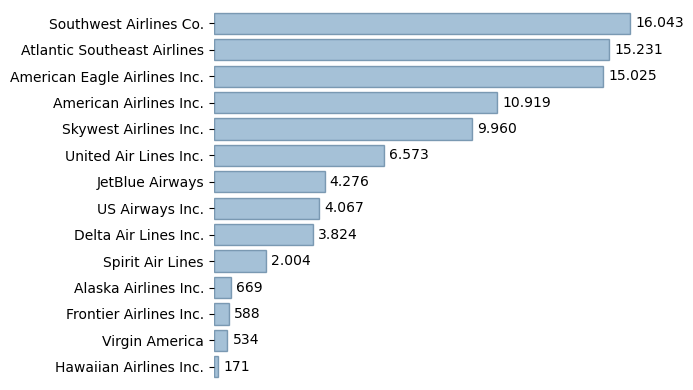

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

cancellations = airlines_metrics_df[['airline', 'cancellations']]

# Datframe nach Stornierungen absteigend sortiert
cancellations_sorted = cancellations.sort_values(by="cancellations", ascending=False)

# Visualisierung des DataFrames als liegendes Balkendiagramm
plt.figure(figsize=(7, 4))
barplot = sns.barplot(
    data=cancellations_sorted,
    y='airline',
    x='cancellations',
    orient='h',
    color='#68A1CF',  # Spezifische Farbe für die Balken
    edgecolor='#4B7394',  # Farbe der Linien der Balken
    alpha=0.65  # Angepasste Transparenz für eine klare Farbangabe
)

# Rahmen (Spines) links, oben und unten entfernen
sns.despine(left=True, bottom=True, top=True)

# Entferne die x-Achse
barplot.get_xaxis().set_visible(False)

# Entferne den Titel der y-Achse
barplot.set_ylabel('')

# Erhöhe den Abstand zum Balken für die Datenlabels
label_padding = 200  

# Füge Datenlabels im deutschen Zahlenformat hinzu, ohne Nachkommastellen
for index, value in enumerate(cancellations_sorted['cancellations']):
    formatted_value = "{:,.0f}".format(value).replace(",", ".")
    plt.text(value + label_padding, index, formatted_value, va='center', color='black')

plt.tight_layout()
plt.show()